In [1]:
import numpy
import tensorflow as tf
import pandas
pandas.set_option('display.precision',10)
from tensorflow.keras import layers
##from tf.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
# load dataset
df = pandas.read_csv("datasets - SIF.csv")
df.head()

,game,ranking_idol,event_type,year,month,duration_days,t1_cutoff,t2_cutoff,t3_cutoff
0,SIF,minami_kotori,token,2013,5,14,24781,15000,10000
1,SIF,sonoda_umi,token,2013,5,14,30655,15000,10000
2,SIF,yazawa_nico,token,2013,6,13,47472,31330,10000
3,SIF,minami_kotori,token,2013,6,9,26333,16246,10000
4,SIF,sonoda_umi,token,2013,7,7,26846,16800,10000


In [4]:
#One hot encoding
#Encode game
game = df['game']
game_dummy = pandas.get_dummies(game,prefix='game')
game_dummy.head()

,game_SIF
0,1
1,1
2,1
3,1
4,1


In [5]:
#Encode Idols
idol = df['ranking_idol']
idol_dummy = pandas.get_dummies(idol,prefix='idol')
idol_dummy.head()

,idol_ayase_eli,idol_hoshizora_rin,idol_koizumi_hanayo,idol_kousaka_honoka,idol_kunikida_hanamaru,idol_kurosawa_dia,idol_kurosawa_ruby,idol_matsuura_kanan,idol_minami_kotori,idol_nishikino_maki,idol_ohara_mari,idol_sakurauchi_riko,idol_sonoda_umi,idol_takami_chika,idol_toujou_nozomi,idol_tsushima_yoshiko,idol_watanabe_you,idol_yazawa_nico
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [6]:
#Encode Event Types
event_type = df['event_type']
event_type_dummy = pandas.get_dummies(event_type,prefix='event_type')
event_type_dummy.head()

,event_type_challenge_festival,event_type_friendly_match,event_type_medley_festival,event_type_score_match,event_type_token,event_type_touring_rally
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [7]:
#Drop Data
df.drop(['game'],axis=1,inplace=True)
df.drop(['ranking_idol'],axis=1,inplace=True)
df.drop(['event_type'],axis=1,inplace=True)
df.head()

,year,month,duration_days,t1_cutoff,t2_cutoff,t3_cutoff
0,2013,5,14,24781,15000,10000
1,2013,5,14,30655,15000,10000
2,2013,6,13,47472,31330,10000
3,2013,6,9,26333,16246,10000
4,2013,7,7,26846,16800,10000


In [8]:
#Concat Data
df = pandas.concat([game_dummy,idol_dummy,event_type_dummy,df],axis=1)
df.head()

,game_SIF,idol_ayase_eli,idol_hoshizora_rin,idol_koizumi_hanayo,idol_kousaka_honoka,idol_kunikida_hanamaru,idol_kurosawa_dia,idol_kurosawa_ruby,idol_matsuura_kanan,idol_minami_kotori,...,event_type_medley_festival,event_type_score_match,event_type_token,event_type_touring_rally,year,month,duration_days,t1_cutoff,t2_cutoff,t3_cutoff
0,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,2013,5,14,24781,15000,10000
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,2013,5,14,30655,15000,10000
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,2013,6,13,47472,31330,10000
3,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,2013,6,9,26333,16246,10000
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,2013,7,7,26846,16800,10000


In [9]:
df.shape

(142, 31)

In [26]:
#Zscoring
df['t1_zscore'] = (df['t1_cutoff'] - df['t1_cutoff'].mean())/df['t1_cutoff'].std()   
df.head()
df.shape

(142, 32)

In [30]:
#Split data
# split into input (X) and output (Y) variables
dataset = df.values
X = dataset[:,0:28]
Y = dataset[:,31]

In [13]:
# define base model
def baseline_model():
	# create model
	model = tf.keras.Sequential()
	model.add(layers.Dense(28, input_dim=28, kernel_initializer='normal', activation='relu'))
	model.add(layers.Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [14]:
#fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [16]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -2216429113.60 (817516574.46) MSE


In [31]:
#Predict
from tensorflow.keras.models import Sequential
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [32]:
def final_model():
    # create model
    model = Sequential()
    model.add(Dense(56, input_dim=28, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
#     # Compile model
#     model.compile(optimizer = optimizers.RMSprop(lr=0.0001), loss = losses.mean_squared_logarithmic_error, metrics =[metrics.categorical_accuracy])
#     model.fit(X, Y, epochs=1000, verbose=0)
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')
    model.fit(X, Y, epochs=1000,batch_size=16,verbose=0)
    return model

In [33]:
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=final_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Final: %.2f (%.2f) MAE" % (results.mean(), results.std()))

Final: -0.35 (0.17) MAE


In [34]:
ynew = final_model().predict(X)
indexes = [0]*len(X)
for i in range(len(X)):
    print("Actual=%s, Predicted=%s" % (Y[i], ynew[i]))
    indexes[i] = i

Actual=-1.638827886351637, Predicted=[-1.0332565]
Actual=-1.5089299300074834, Predicted=[-1.3154691]
Actual=-1.13703787487646, Predicted=[-1.2421373]
Actual=-1.604506873711847, Predicted=[-1.0716546]
Actual=-1.5931623637349062, Predicted=[-1.3423873]
Actual=-1.2011465189761708, Predicted=[-1.3465852]
Actual=-1.2909738085011881, Predicted=[-1.1639045]
Actual=-1.273945986508509, Predicted=[-1.3559352]
Actual=-1.3650337771420753, Predicted=[-1.3090874]
Actual=-1.3995317022181528, Predicted=[-1.2598609]
Actual=0.12726685105271118, Predicted=[0.2707491]
Actual=-1.2447554345210587, Predicted=[-1.1051664]
Actual=0.3270673337849938, Predicted=[0.51091677]
Actual=-1.3862632694965846, Predicted=[-1.3109802]
Actual=0.07052218711347076, Predicted=[0.12631465]
Actual=-1.1760691811324067, Predicted=[-1.2166841]
Actual=0.20088453860287928, Predicted=[0.05248024]
Actual=-1.2257815757292159, Predicted=[-1.3774816]
Actual=0.20563906032810791, Predicted=[0.02980283]
Actual=-1.2917699144644823, Predicted=

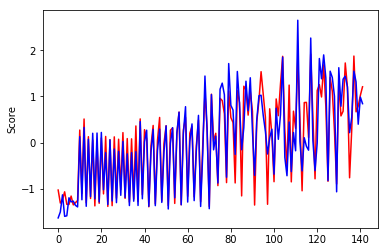

In [35]:
#Visualization
import matplotlib.pyplot as plt
plt.plot(indexes,ynew,color='red')
plt.plot(indexes,Y,color='blue')
plt.ylabel('Score')
plt.show()

In [36]:
#Visualize regularized
Y_reg = df['t1_cutoff']
indexes = [0]*len(X)
y_pred_normalized = [0]*len(X)
for i in range(len(X)):
    res = (ynew[i]*Y_reg.std())+Y_reg.mean()
    print("Actual=%s, Predicted=%s" % (Y_reg[i], res))
    indexes[i] = i
    y_pred_normalized[i] = res

Actual=24781, Predicted=[52165.004]
Actual=30655, Predicted=[39403.316]
Actual=47472, Predicted=[42719.39]
Actual=26333, Predicted=[50428.64]
Actual=26846, Predicted=[38186.074]
Actual=44573, Predicted=[37996.25]
Actual=40511, Predicted=[46257.086]
Actual=41281, Predicted=[37573.438]
Actual=37162, Predicted=[39691.902]
Actual=35602, Predicted=[41917.93]
Actual=104644, Predicted=[111132.28]
Actual=42601, Predicted=[48913.23]
Actual=113679, Predicted=[121992.69]
Actual=36202, Predicted=[39606.31]
Actual=102078, Predicted=[104600.94]
Actual=45707, Predicted=[43870.387]
Actual=107973, Predicted=[101262.14]
Actual=43459, Predicted=[36599.11]
Actual=108188, Predicted=[100236.664]
Actual=40475, Predicted=[39134.992]
Actual=108790, Predicted=[103361.12]
Actual=52407, Predicted=[48392.324]
Actual=88955, Predicted=[104833.16]
Actual=37970, Predicted=[36092.33]
Actual=101520, Predicted=[101716.414]
Actual=41462, Predicted=[36830.89]
Actual=92486, Predicted=[104434.62]
Actual=39803, Predicted=[441

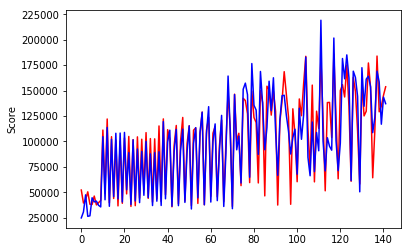

In [37]:
#Visualization
import matplotlib.pyplot as plt
plt.plot(indexes[0:50], y_pred_normalized,color='red')
plt.plot(indexes,Y_reg,color='blue')
plt.ylabel('Score')
plt.show()